# Team Rubber Duckers
#### 1. Deepansh Bhatia
#### 2. Daniel Haseler
#### 3. Juan Vargas
#### 4. Wyatt Hansen

#### See us at table 60!

### Importing the dataset

In [119]:
import pandas as pd
# read the file
train_set = pd.read_csv("equip_failures_training_set.csv")
y = train_set.iloc[:, 1].values

### Adding na columns

In [120]:
# adding the binary na columns for each sensor value
for key in train_set:
    if "sensor" in key:
        train_set[key + "_na"] = [1 if train_set[key][i] == "na" else 0 for i in range(len(train_set[key]))]

In [196]:
X = train_set.iloc[:, 2:].values
import numpy as np
X = np.where(X == "na", 0, X)

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

from sklearn.externals.joblib import dump, load
dump(sc, 'std_scaler.bin', compress=True)

### Building the ANN model

In [ ]:
import keras
import TensorFlow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import LSTM


# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 170, kernel_initializer = 'uniform', activation = 'relu', input_dim = 340))

classifier.add(Dropout(rate=0.05))

classifier.add(Dense(units = 65, kernel_initializer = 'uniform', activation = 'linear'))
classifier.add(Dropout(rate=0.015))

    
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

adamOp = keras.optimizers.Adam(lr = 0.00005, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, amsgrad = False)

classifier.compile(optimizer = adamOp, loss = 'binary_crossentropy', metrics = ['accuracy'])




### Fitting the ANN normally

In [ ]:
# Fitting the ANN to the Training set
checkpoint = keras.callbacks.ModelCheckpoint(filepath="model2.h5", verbose=0, monitor='val_loss', save_best_only=True)      #only needed if you want save as you go, allowing for BEST model not just last model
history = classifier.fit(X_train, y_train, epochs=25, validation_split=0.05, verbose=1, callbacks = [checkpoint])

### Testing it to gauge its accuracy

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

### Saving the model

In [ ]:
classifier_json = classifier.to_json()
with open("classifier.json", "w") as json_file:
    json_file.write(classifier_json)

classifier.save_weights("weights.h5")

## Building an SOM

In [152]:
from sklearn.preprocessing import MinMaxScaler
scale_object = MinMaxScaler(feature_range = (0,1))
X_som = scale_object.fit_transform(X)

In [200]:
from minisom import MiniSom
som = MiniSom(x = 34, y = 34, input_len = 340, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X_som)
som.train_random(data = X_som, num_iteration = 1000)

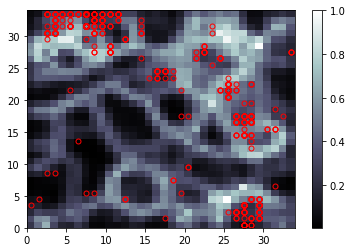

In [201]:
from pylab import bone, pcolor, colorbar, plot, show
pcolor(som.distance_map().T)
colorbar()
markers = ['', 'o']
colors = ['g', 'r']
for i, x in enumerate(X_som):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 5,
         markeredgewidth = 1)
show()

In [202]:
mappings = som.win_map(X_som)

In [204]:
print(scale_object.inverse_transform(mappings[(27,3)]).astype(int))

[[753793      0    622 ...      0      0      0]
 [297814      0   1114 ...      0      0      0]
 [590444      0      0 ...      0      0      0]
 ...
 [745702      0    494 ...      0      0      0]
 [425318      0      0 ...      0      0      0]
 [363236      0      0 ...      0      0      0]]


## Loading the saved model to predict test results

In [155]:
test_set = pd.read_csv("equip_failures_test_set.csv")

for key in test_set:
    if "sensor" in key:
        test_set[key + "_na"] = [1 if test_set[key][i] == "na" else 0 for i in range(len(test_set[key]))]

In [ ]:
new_X = test_set.iloc[:, 1:].values
new_X = np.where(new_X == "na", 0, new_X)
sc=load('std_scaler.bin')
new_X = sc.fit_transform(new_X)


In [ ]:
from keras.models import model_from_json
json_file = open("classifier.json", "r")
loaded_json = json_file.read()
json_file.close()
classifier = model_from_json(loaded_json)
classifier.load_weights("weights.h5")

In [ ]:
new_predictions = classifier.predict(new_X)
new_predictions = new_predictions > 0.5
np.savetxt("test_results.txt", new_predictions, fmt = "%d")

In [ ]:
with open("test_results.txt","r") as pred_file:
    fout = open("results_1.txt", "w")
    fout.write("id,target\n")
    for idx, val in enumerate(pred_file):
        fout.write(str(str(idx + 1) + "," + str(val)))
        

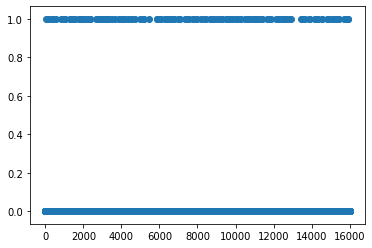

In [158]:
import matplotlib.pyplot as plt
indices = [i for i in range(1,16002)]
plt.scatter(indices, new_predictions)

151


([<matplotlib.patches.Wedge at 0x1fc9e4ac828>,
 [Text(-0.032606826829111965, -1.0995166187212164, 'Above'),
  Text(0.03260681074408498, 1.0995166191982273, 'Below')])

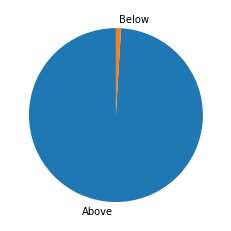

In [163]:
nb_ones = np.count_nonzero(new_predictions)
nb_zeros = new_predictions.shape[0] - nb_ones
count = [nb_zeros, nb_ones]
labels = ["Above", "Below"]
plt.pie(count, labels = labels, startangle = 90)